<a href="https://colab.research.google.com/github/enznoor/AnomalyDetection/blob/main/FIP_Libra_Step3_MyModel_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dgl

In [ ]:
!pip install node2vec

In [ ]:
from node2vec.edges import HadamardEmbedder
from gensim.models import Word2Vec
import random
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import torch.optim as optim
import dgl.function as fn
from dgl.nn import SAGEConv

In [ ]:
!pip install -q torch-geometric

In [ ]:
from google.colab import drive
import networkx as nx
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
#from dgl.nn import GraphConv
#from dgl.nn import SAGEConv
import dgl.nn as dglnn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
path='drive/MyDrive/Term_05/FinalProposal/Data/'
pathCommunity='drive/MyDrive/Term_05/FinalProposal/Data/Community/'
train_edge_index=np.load(path+'train_edge_index.npy')
train_edgelist=np.load(path+'train_edgelist.npy')
train_edge_weight=np.load(path+'train_edge_weight.npy')
train_x=np.load(path+'train_x.npy')
train_y=np.load(path+'train_y.npy')
test_edge_index=np.load(path+'test_edge_index.npy')
test_edgelist=np.load(path+'test_edgelist.npy')
test_edge_weight=np.load(path+'test_edge_weight.npy')
test_x=np.load(path+'test_x.npy')
test_y=np.load(path+'test_y.npy')
train_elabel=np.load(path+'edge_y_train.npy')
test_elabel=np.load(path+'edge_y_test.npy')

In [ ]:
nodedf=pd.read_csv(path + 'LibraReduceNodeInfo.csv')
edgedf=pd.read_csv(path + 'LibraReduceEdgeInfo.csv')

In [ ]:
print(edgedf.shape)
print(nodedf.shape)

(370918, 6)
(202426, 22)


In [ ]:
loaded_trainData=np.load(path+'train_node.npy')
loaded_testData=np.load(path+'test_node.npy')
traindf= pd.DataFrame(loaded_trainData, columns=['NewNodeId'])
testdf= pd.DataFrame(loaded_testData, columns=['NewNodeId'])

traindf['NewNodeId'] = traindf['NewNodeId'].astype(int)
traindata_df = pd.merge(traindf,nodedf, on='NewNodeId', how='inner')
testdata_df = pd.merge(testdf,nodedf, on='NewNodeId', how='inner')

In [ ]:
train_idx=torch.tensor(traindata_df.index, dtype = torch.long)
test_idx=torch.tensor(testdata_df.index, dtype = torch.long)
#valid_idx=torch.tensor(validate.index, dtype = torch.long)

In [ ]:
edgedf.insert(1, "elabel", 0)
edgedf["elabel"] = np.where(edgedf["nr_alerts"] > 0, 1, 0)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ,'elabel' ]
G=nx.from_pandas_edgelist(
            df=edgedf,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',G.number_of_edges())
print('number_of_nodes: ',G.number_of_nodes())

number_of_edges:  370918
number_of_nodes:  202426


# Create Train and Test Graph for edge Classification

In [ ]:
df1=pd.DataFrame(train_edgelist)
df2=pd.DataFrame(train_edge_weight)
train_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#--------------------------------------------------------------------------------
train_edgelist_G = train_edgelist_G.rename(columns={'0_x': 'id_source'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_x': 'id_destination'})
train_edgelist_G = train_edgelist_G.rename(columns={'0_y': 'cum_amount'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
train_edgelist_G['eLabel']=pd.DataFrame(train_elabel)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
train_G=nx.from_pandas_edgelist(
            df=train_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',train_G.number_of_edges())
print('number_of_nodes: ',train_G.number_of_nodes())

number_of_edges:  230907
number_of_nodes:  135447


In [ ]:
df1=pd.DataFrame(test_edgelist)
df2=pd.DataFrame(test_edge_weight)
test_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#--------------------------------------------------------------------------------
test_edgelist_G = test_edgelist_G.rename(columns={'0_x': 'id_source'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_x': 'id_destination'})
test_edgelist_G = test_edgelist_G.rename(columns={'0_y': 'cum_amount'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
test_edgelist_G['eLabel']=pd.DataFrame(test_elabel)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
test_G=nx.from_pandas_edgelist(
            df=test_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',test_G.number_of_edges())
print('number_of_nodes: ',test_G.number_of_nodes())

number_of_edges:  16222
number_of_nodes:  12963


In [ ]:
#train_G = G.subgraph(loaded_trainData)
#test_G = G.subgraph(loaded_testData)
print('number_of_edges train_graph: ',train_G.number_of_edges())
print('number_of_nodes train_graph: ',train_G.number_of_nodes())
print('number_of_edges test_graph: ',test_G.number_of_edges())
print('number_of_nodes test_graph: ',test_G.number_of_nodes())


number_of_edges train_graph:  230907
number_of_nodes train_graph:  135447
number_of_edges test_graph:  16222
number_of_nodes test_graph:  12963


# Set Attribute  to Train and Test Graph

In [ ]:
trainNode_G=list(train_G.nodes())
trainNode=pd.DataFrame(trainNode_G, columns=['NewNodeId'])
traindata_df = pd.merge(trainNode,nodedf, on='NewNodeId', how='inner')

testNode_G=list(test_G.nodes())
testNode=pd.DataFrame(testNode_G, columns=['NewNodeId'])
testdata_df = pd.merge(testNode,nodedf, on='NewNodeId', how='inner')

In [ ]:
# featurName=['f_amount_in','f_amount_out','f_egored_amount_in','f_egored_amount_out','Label']
# trainNode_x=traindata_df[featurName].values
# trainNode_y=traindata_df['L_alert'].values

# testNode_x=testdata_df[featurName].values
# testNode_y=testdata_df['L_alert'].values

In [ ]:
col=['NewNodeId']

In [ ]:
df1=traindata_df[col].where(traindata_df['L_alert'] ==1).dropna()
df2=testdata_df[col].where(testdata_df['L_alert'] ==1).dropna()

In [ ]:
ListAnomalNode_train=df1['NewNodeId'].values.tolist()
ListAnomalNode_test=df2['NewNodeId'].values.tolist()

In [ ]:
len(ListAnomalNode_train)

335

# Community Detection For Train and Test Graph

In [ ]:
# !pip install cdlib
# from cdlib import algorithms
#from cdlib import NodeClustering
#from cdlib import evaluation

In [ ]:
from networkx.algorithms.community import louvain_communities

In [ ]:
partitions_TG=louvain_communities(train_G)
print('partitions number of train:',len(partitions_TG))

partitions_TST=louvain_communities(test_G)
print('partitions number of test:',len(partitions_TST))

partitions number of train: 13867
partitions number of test: 2093


In [ ]:
for i, community in enumerate(partitions_TG):
    if len(community)>1000:
        print(i,community)

73 {106497, 192514, 155650, 45060, 20481, 147467, 18, 106515, 98324, 45076, 45082, 110621, 114718, 98335, 151592, 45096, 147510, 155702, 4150, 73782, 172093, 151614, 81985, 86087, 180305, 20562, 131153, 176209, 36951, 20579, 61539, 127080, 188532, 196730, 188538, 172156, 16510, 139415, 155802, 98460, 102557, 12454, 131245, 16559, 61618, 159927, 32952, 151738, 114879, 94403, 139462, 199, 143561, 102605, 155863, 123109, 188647, 188660, 28919, 57592, 123131, 180476, 180475, 8447, 28928, 143619, 82180, 151813, 69894, 151816, 188685, 45338, 106782, 176417, 45346, 188708, 201014, 147769, 45373, 318, 37183, 172352, 98623, 16702, 65856, 184646, 172358, 164169, 33098, 334, 37198, 78161, 94546, 4440, 102744, 24929, 110946, 119144, 69993, 131434, 176493, 29039, 65906, 119162, 196987, 151942, 65928, 94604, 45452, 4494, 164241, 164244, 160151, 98713, 176544, 131491, 49573, 53678, 70064, 151985, 438, 70075, 160191, 201155, 82376, 94671, 70100, 102871, 106969, 180698, 20956, 37342, 61922, 139754, 123

In [ ]:
c=0
for i in ListAnomalNode_test:
    for node in test_G.nodes():
        if node==i:
            #print(node)
            c=c+1
print(c)


74


In [ ]:
# for _, row in traindata_df.iterrows():
#     #print(row['NodeId'] , row['L_alert'])
#     nx.set_node_attributes(train_G, {row['NodeId']: row['L_alert']} , 'L_alert')
# #-----------------------------------------
# for _, row in testdata_df.iterrows():
#     #print(row['NodeId'] , row['L_alert'])
#     nx.set_node_attributes(test_G, {row['NodeId']: row['L_alert']} , 'L_alert')

In [ ]:
# node_attributes = nx.get_node_attributes(train_G, 'L_alert')
# ListAnomalNode=[]
# for node, label in node_attributes.items():
#     if  label==1:
#         ListAnomalNode.append(node)
#         #print(f"Node {node}: L_alert {label}")
# #---------------------------------------------------------------
# node_attributes_tst = nx.get_node_attributes(test_G, 'L_alert')
# ListAnomalNode_tst=[]
# for node, label in node_attributes_tst.items():
#     if  label==1:
#         ListAnomalNode_tst.append(node)
#         #print(f"Node {node}: L_alert {label}")

In [ ]:
def Get_FinancialFlow(NodeList,featurename,df):
    filtered_df = df[df['NewNodeId'].isin(NodeList)]
    sumofvalue=filtered_df[featurename].sum()
    #print(sumofvalue)

    return sumofvalue

In [ ]:
def Get_partitionList(partitions ,G , ListAnomalNode,df):
    partitions_List=[]
    for index , community  in enumerate(partitions):
        subgraph = G.subgraph(community)
        A = nx.adjacency_matrix(subgraph)
        degrees = np.sum(A, axis=1)
        D = np.diag(degrees)
        L = D - A
        #-------------Get Anomal Node--------------
        CntAnomalNode=0
        Label=0
        for i in ListAnomalNode:
            if i in community:
                CntAnomalNode=CntAnomalNode+1
        if  CntAnomalNode>0:
            Label=1

        #CM_Dictionary= [index , len(CM) , CntAnomalNode ]
        Laplacianmatrix=torch.tensor(L)
        #------------------------------------------
        val_amount_out=Get_FinancialFlow(community,'f_amount_out',df)
        val_amount_in=Get_FinancialFlow(community,'f_amount_in',df)
        val_nr_trans_in=Get_FinancialFlow(community,'f_nr_trans_in',df)
        val_nr_trans_out=Get_FinancialFlow(community,'f_nr_trans_out',df)
        #------------------------------------------
        item=[index,community,subgraph,L,len(community),CntAnomalNode,val_amount_in,val_amount_out,val_nr_trans_in,val_nr_trans_out,Label]
        partitions_List.append(item)
    return partitions_List

In [ ]:
#DF_partitions_List_TG['Nodelist'][1]

{33395, 168146}

In [ ]:
partitions_List_TG=Get_partitionList(partitions_TG ,train_G , ListAnomalNode_train, traindata_df)
partitions_List_tst=Get_partitionList(partitions_TST ,test_G , ListAnomalNode_test, testdata_df)

columnname=['Index','Nodelist' ,'Subgraph' ,'Laplacian' , 'len_Community' , 'CntAnomalNode','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','Label']
DF_partitions_List_TG=pd.DataFrame(partitions_List_TG ,  columns=columnname)
DF_partitions_List_TG.to_csv(path +  'partitions_train_List.csv', index=False)

DF_partitions_List_TST=pd.DataFrame(partitions_List_tst ,  columns=columnname)
DF_partitions_List_TST.to_csv(path +  'partitions_test_List.csv', index=False)


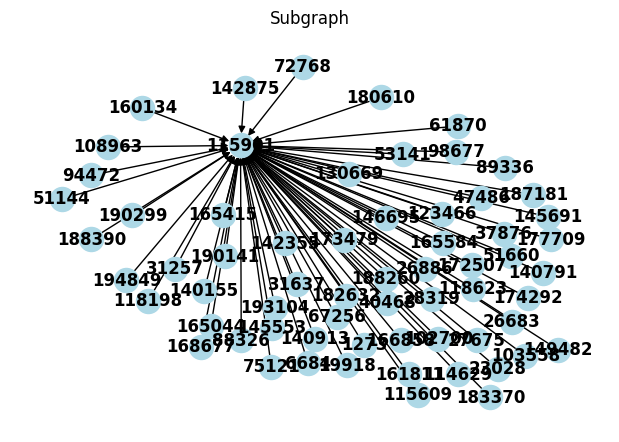

In [ ]:
plt.figure(figsize=(6, 4))
nx.draw(DF_partitions_List_TG['Subgraph'][0], with_labels=True, node_color='lightblue', font_weight='bold')
plt.title('Subgraph')
plt.show()

In [ ]:
# subgraph_TG=[]
# for i, community in enumerate(partitions_TG):
#      subgraph = train_G.subgraph(community)
#      item= [i,community,subgraph]
#      subgraph_TG.append(item)
#      #nx.write_edgelist(subgraph, pathCommunity + f"community_{i}_subgraph.txt")
#      #print(f"Subgraph for Community {i} has been created and saved." , c)

In [ ]:
# subgraph_TG[0][2]
# subgraph_Info[1][0]

In [ ]:
def Get_CommunityID(node , membership):
    for index , item in enumerate(membership):
        CMIndex=membership[index][0]
        CMNode=membership[index][1]
        if node in CMNode:
            break
    return CMIndex

In [ ]:
def Get_edgeList(DF_partitions_List,G):
    ColumnName=['Index','Nodelist']
    membership=list(DF_partitions_List[ColumnName].to_numpy())

    edglistem=[]
    cnt=0
    for node1,node2 in G.edges:
        #cnt=cnt+1
        CMIndex_node1=Get_CommunityID(node1 , membership)
        CMIndex_node2=Get_CommunityID(node2, membership)
        if CMIndex_node1 != CMIndex_node2:
            edgeitem=[CMIndex_node1 , CMIndex_node2]
            edglistem.append(edgeitem)
    #-----------------------------------------------
    columnname=['source_id','destination_id']
    DF_AccGrpEdge=pd.DataFrame(edglistem ,  columns=columnname)
    return DF_AccGrpEdge

In [ ]:
DF_AccGrpEdge_TG=Get_edgeList(DF_partitions_List_TG,train_G)
DF_AccGrpEdge_TST=Get_edgeList(DF_partitions_List_TST,test_G)

DF_AccGrpEdge_TG.to_csv(path +  'AccGrpEdge_train.csv', index=False)
DF_AccGrpEdge_TST.to_csv(path +  'AccGrpEdge_test.csv', index=False)

In [ ]:
#unique_df = DF_AccGrpEdge.drop_duplicates()

In [ ]:
# c=0
# for i in ListAnomalNode_test:
#     for node in test_G.nodes():
#         if node==i:
#             print(node)
# print(c)

# Create AccGrp Graph

In [ ]:
train_Grpedgedf=pd.read_csv(path + 'AccGrpEdge_train.csv')
test_Grpedgedf=pd.read_csv(path + 'AccGrpEdge_test.csv')

train_partitiondf=pd.read_csv(path + 'partitions_train_List.csv')
test_partitiondf=pd.read_csv(path + 'partitions_test_List.csv')

In [ ]:
#AttrEge=['cum_amount', 'nr_transactions']
Grp_Train_G=nx.from_pandas_edgelist(
            df=train_Grpedgedf,
            source="source_id",
            target="destination_id",
            #edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges for train graph: ',Grp_Train_G.number_of_edges())
print('number_of_nodes for train graph: ',Grp_Train_G.number_of_nodes())

#AttrEge=['cum_amount', 'nr_transactions']
Grp_Test_G=nx.from_pandas_edgelist(
            df=test_Grpedgedf,
            source="source_id",
            target="destination_id",
            #edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges for test graph: ',Grp_Test_G.number_of_edges())
print('number_of_nodes for test graph: ',Grp_Test_G.number_of_nodes())

number_of_edges for train graph:  82090
number_of_nodes for train graph:  11520
number_of_edges for test graph:  3799
number_of_nodes for test graph:  1246


In [ ]:
nodelist=Grp_Train_G.nodes()
for node in list(train_partitiondf['Index'].to_numpy()):
    if node not in nodelist:
        Grp_Train_G.add_edge(node,node)
        #print(node)
#-----------------------------------------------------------------
nodelist=Grp_Test_G.nodes()
for node in list(test_partitiondf['Index'].to_numpy()):
    if node not in nodelist:
        Grp_Test_G.add_edge(node,node)
        #print(node)


In [ ]:
print('number_of_edges: ',Grp_Train_G.number_of_edges())
print('number_of_nodes: ',Grp_Train_G.number_of_nodes())
print('----------------------------------------------')
print('number_of_edges: ',Grp_Test_G.number_of_edges())
print('number_of_nodes: ',Grp_Test_G.number_of_nodes())

number_of_edges:  84437
number_of_nodes:  13867
----------------------------------------------
number_of_edges:  4646
number_of_nodes:  2093


In [ ]:
Grp_train_graph=dgl.DGLGraph(Grp_Train_G)
Grp_test_graph=dgl.DGLGraph(Grp_Test_G)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [ ]:
#torch.tensor((DF_partitions_List_TG['Laplacian'].values).tolist())

# sample for Convert multiple dimention to bigdimention

In [ ]:
def convert_to_largest_dimension(matrix):
    max_length = max(len(column) for column in matrix.T)  # Find the maximum length among all columns
    padded_matrix = np.zeros((max_length, matrix.shape[1]))  # Initialize a matrix of zeros with the new dimensions

    for i, column in enumerate(matrix.T):
        padded_matrix[:len(column), i] = column  # Copy values from original column to padded column

    return padded_matrix

# Example usage
original_matrix = np.array([[1, 2, 3],
                            [4, 5],
                            [6, 7, 8, 9]])
padded_matrix = convert_to_largest_dimension(original_matrix)
print("Original Matrix:")
print(original_matrix)
print("\nPadded Matrix:")
print(padded_matrix)

#Node embedding and edge embedding

In [ ]:
node2vec = Node2Vec(Grp_Train_G, dimensions=2)
# Embed nodes
modelTG = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = modelTG.wv

modelTG.wv.save_word2vec_format(path +  'EMBEDDING_Train_AccGrp.emb')

Computing transition probabilities:   0%|          | 0/13867 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


In [ ]:
modelTG.save(path +'modelTsTG_Train_AccGrp.wv')

In [ ]:
node2vec = Node2Vec(Grp_Test_G, dimensions=2)
# Embed nodes
modelTstG = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = modelTstG.wv

modelTstG.wv.save_word2vec_format(path +  'EMBEDDING_Test_AccGrp.emb')

Computing transition probabilities:   0%|          | 0/2093 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


In [ ]:
modelTstG.save(path +'modelTstG_test_AccGrp.wv')

In [ ]:
#---------------------Load Data Model -------------------------------------------------
train_node_embeddings =KeyedVectors.load_word2vec_format(path +  'EMBEDDING_Train_AccGrp.emb')
Train_model = Word2Vec.load(path + 'modelTsTG_Train_AccGrp.wv')
test_node_embeddings =KeyedVectors.load_word2vec_format(path +  'EMBEDDING_Test_AccGrp.emb')
Test_model = Word2Vec.load(path + 'modelTstG_test_AccGrp.wv')

In [ ]:
#edges_embs = HadamardEmbedder(keyed_vectors=Train_model.wv)

In [ ]:
train_embeddings=Train_model.wv
node_embeddingslist = train_embeddings.vectors.tolist()
node_features_train=torch.tensor(node_embeddingslist , dtype = torch.float)

test_embeddings=Test_model.wv
node_embeddingslist = test_embeddings.vectors.tolist()
node_features_test=torch.tensor(node_embeddingslist , dtype = torch.float)

In [ ]:
# Grp_X_train=torch.tensor(node_features_train)
# Grp_y_train= torch.tensor((train_partitiondf['Label'].values).tolist(), dtype=torch.long)
# Grp_X_test=torch.tensor(node_features_test)
# Grp_y_test=torch.tensor((test_partitiondf['Label'].values).tolist(), dtype=torch.long)

<ipython-input-364-a234d623f166>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Grp_X_train=torch.tensor(node_features_train)
<ipython-input-364-a234d623f166>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Grp_X_test=torch.tensor(node_features_test)


In [ ]:
# # #featurecolname=['Laplacian','len_Community']
# featurecolname=['len_Community']
# Grp_X_train=torch.tensor((train_partitiondf[featurecolname].values).tolist(), dtype=torch.float32)
# Grp_y_train= torch.tensor((train_partitiondf['Label'].values).tolist(), dtype=torch.long)
# Grp_X_test=torch.tensor((test_partitiondf[featurecolname].values).tolist(), dtype=torch.float32)
# Grp_y_test= torch.tensor((test_partitiondf['Label'].values).tolist(), dtype=torch.long)


# Group prediction

In [ ]:
#featurename=['len_Community' ,'f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']
featurename=['f_amount_in','f_amount_out', 'f_nr_trans_in','f_nr_trans_out']
#Grp_X_train=torch.tensor((train_partitiondf[featurename].values).tolist(), dtype=torch.float)
#Grp_X_test =torch.tensor((test_partitiondf[featurename].values).tolist(), dtype=torch.float)
#Grp_X_train=torch.tensor(node_features_train)
Grp_y_train= torch.tensor((train_partitiondf['Label'].values).tolist(), dtype=torch.long)
#Grp_X_test=torch.tensor(node_features_test)
Grp_y_test=torch.tensor((test_partitiondf['Label'].values).tolist(), dtype=torch.long)

In [ ]:
listfeaturel_test=(test_partitiondf[featurename].values).tolist()
merged_featurelist_test = []
for item1, item2 in zip(listfeaturel_test, node_features_test.tolist()):
    merged_item = item1 + item2  # Concatenate the lists
    merged_featurelist_test.append(merged_item)


listfeaturel_train=(train_partitiondf[featurename].values).tolist()
merged_featurelist_train = []
for item1, item2 in zip(listfeaturel_train, node_features_train.tolist()):
    merged_item = item1 + item2  # Concatenate the lists
    merged_featurelist_train.append(merged_item)

#-------------------------------------------------------------------------------------------
Grp_X_train=torch.tensor( merged_featurelist_train, dtype=torch.float)
Grp_X_test =torch.tensor(merged_featurelist_test, dtype=torch.float)

In [ ]:
class Grp_Autoencoder(nn.Module):
    def __init__(self):
        super(Grp_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
import tensorflow as tf
seed=42
learning_rate_Grp=0.07
batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
epochs=100
input_dim=Grp_X_train.shape[1]
tf.random.set_seed(42)
autoencoder = Grp_Autoencoder()
classifier = Classifier(autoencoder.encoder)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)


test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In [ ]:
torch.backends.cudnn.deterministic = True

In epoch 0, loss: 6638.722)
In epoch 5, loss: 21472.004)
In epoch 10, loss: 14118.873)
In epoch 15, loss: 9.663)
In epoch 20, loss: 0.828)
In epoch 25, loss: 0.824)
In epoch 30, loss: 0.781)
In epoch 35, loss: 0.733)
In epoch 40, loss: 0.703)
In epoch 45, loss: 0.693)
In epoch 50, loss: 0.695)
In epoch 55, loss: 0.697)
In epoch 60, loss: 0.697)
In epoch 65, loss: 0.695)
In epoch 70, loss: 0.694)
In epoch 75, loss: 0.693)
In epoch 80, loss: 0.693)
In epoch 85, loss: 0.693)
In epoch 90, loss: 0.693)
In epoch 95, loss: 0.693)


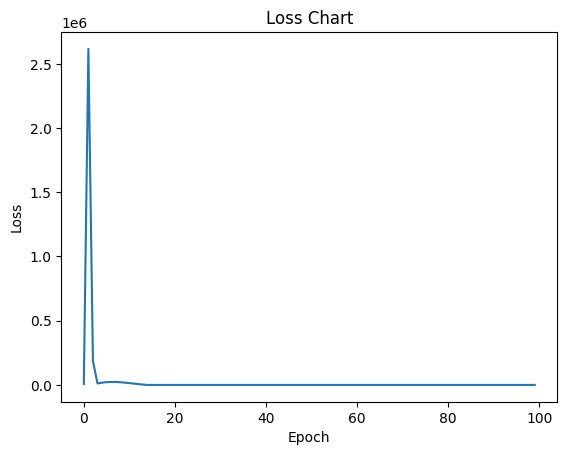

In [ ]:
Grp_model=train(model=classifier, train_loader=train_loader_Grp, epochs=epochs , class_weights=Grp_class_weights , learning_rate=learning_rate_Grp)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2035
           1       0.11      0.24      0.16        58

    accuracy                           0.93      2093
   macro avg       0.55      0.59      0.56      2093
weighted avg       0.95      0.93      0.94      2093



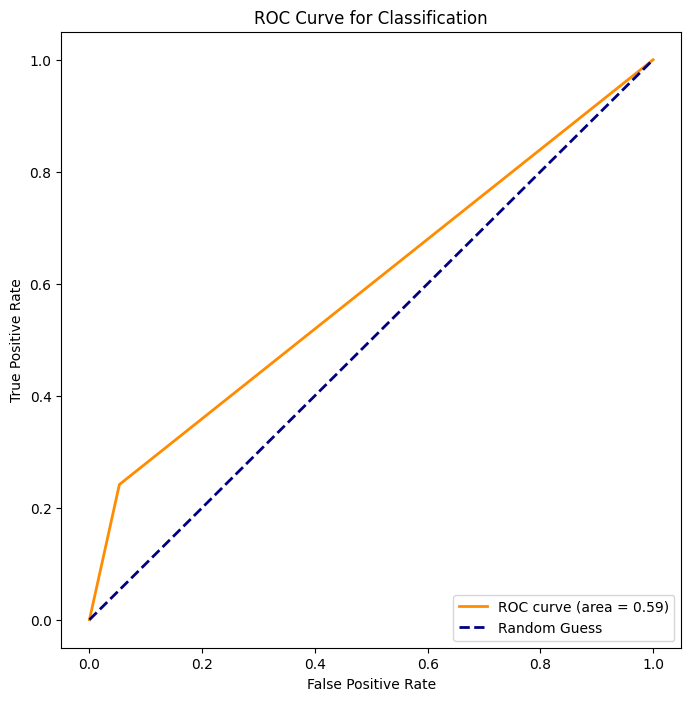

0.9273769855499268

In [ ]:
evaluate(model=Grp_model, test_loader=test_loader_Grp)

# Node embedding and edge embedding

In [ ]:
#---------------------Load Data Model -------------------------------------------------
train_node_embeddings =KeyedVectors.load_word2vec_format(path +  'EMBEDDING_Train.emb')
Train_model = Word2Vec.load(path + 'modelTsTG_Train.wv')
test_node_embeddings =KeyedVectors.load_word2vec_format(path +  'EMBEDDING_Test.emb')
Test_model = Word2Vec.load(path + 'modelTstG_test.wv')

In [ ]:
train_graph=dgl.DGLGraph(train_G)
test_graph=dgl.DGLGraph(test_G)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [ ]:
edges_embs = HadamardEmbedder(keyed_vectors=Train_model.wv)

In [ ]:
node_features.shape

torch.Size([12963, 3])

In [ ]:
train_embeddings=Train_model.wv
node_embeddingslist = train_embeddings.vectors.tolist()

node_features=torch.tensor(node_embeddingslist , dtype = torch.float)
train_graph.ndata['feat'] = node_features
#---------------------- Train Node Label ---------------------------------------------
train_graph.ndata['label'] = torch.tensor(traindata_df['L_alert'].values)


edges_embslist=[]
for edge in train_G.edges:
     node1, node2 = edge
     edge_embeddingitem = edges_embs[(str(node1),str(node2))]
     edges_embslist.append(edge_embeddingitem)

train_graph.edata['AttrEge'] =torch.tensor(edges_embslist)
train_graph.edata['eLabel']=torch.tensor(train_edgelist_G['eLabel'].values, dtype=torch.float32)


<ipython-input-54-e87069f3734c>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_graph.edata['AttrEge'] =torch.tensor(edges_embslist)


In [ ]:
edges_embs = HadamardEmbedder(keyed_vectors=Test_model.wv)
test_embeddings=Test_model.wv
node_embeddingslist = test_embeddings.vectors.tolist()

node_features=torch.tensor(node_embeddingslist , dtype = torch.float)
test_graph.ndata['feat'] = node_features
#---------------------- Train Node Label ---------------------------------------------
test_graph.ndata['label'] = torch.tensor(testdata_df['L_alert'].values)


edges_embslist=[]
for edge in test_G.edges:
     node1, node2 = edge
     edge_embeddingitem = edges_embs[(str(node1),str(node2))]
     edges_embslist.append(edge_embeddingitem)

test_graph.edata['AttrEge'] =torch.tensor(edges_embslist)
test_graph.edata['eLabel']=torch.tensor(test_edgelist_G['eLabel'].values, dtype=torch.float32)

#edge_list_src, edge_list_dst = train_graph.edges()
#edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
#edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
#train_edge_index = torch.cat((edge_list_src.unsqueeze(0), edge_list_dst.unsqueeze(0)), dim=0)


# Node Classification

In [ ]:
class n_Autoencoder(nn.Module):
    def __init__(self):
        super(n_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            #nn.Linear(128, 32),
            #nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            #nn.Linear(32, 128),
            #nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
X_train_Node=train_graph.ndata['feat']
y_train_Node= train_graph.ndata['label']
X_test_Node=test_graph.ndata['feat']
y_test_Node= test_graph.ndata['label']

In [ ]:
n_class_weights=Get_class_weights(train_graph.ndata['label'])

In [ ]:
import tensorflow as tf
seed=42
learning_rate_n=0.02
batch_size_n =135447
epochs=50
input_dim=X_train_Node.shape[1]
tf.random.set_seed(42)
autoencoder = n_Autoencoder()
classifier = Classifier(autoencoder.encoder)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(X_train_Node,y_train_Node)
train_loader_node=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_n, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(X_test_Node,y_test_Node)
test_loader_node=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_n, shuffle=False )

In epoch 0, loss: 0.695)
In epoch 5, loss: 0.699)
In epoch 10, loss: 0.692)
In epoch 15, loss: 0.688)
In epoch 20, loss: 0.688)
In epoch 25, loss: 0.686)
In epoch 30, loss: 0.686)
In epoch 35, loss: 0.684)
In epoch 40, loss: 0.683)
In epoch 45, loss: 0.682)


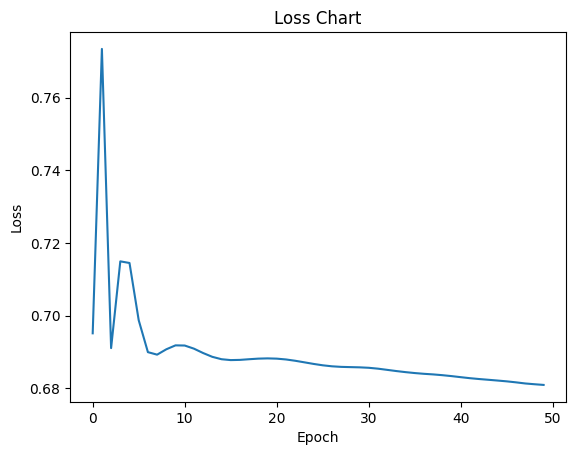

In [ ]:
n_model=train(model=classifier, train_loader=train_loader_node, epochs=epochs , class_weights=n_class_weights , learning_rate=learning_rate_n)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     12889
           1       0.01      0.28      0.02        74

    accuracy                           0.86     12963
   macro avg       0.50      0.57      0.47     12963
weighted avg       0.99      0.86      0.92     12963



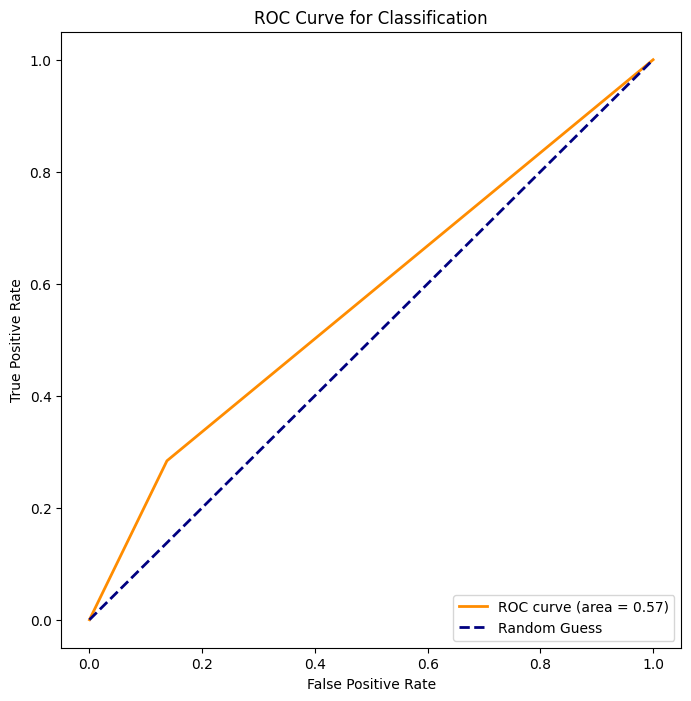

(0.8592146635055542, tensor([1, 1, 1,  ..., 0, 0, 0]))

In [ ]:
evaluate(model=n_model, test_loader=test_loader_node)

#Edge classification

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
           # nn.Linear(64, 32),
           # nn.ReLU(),
            nn.Linear(128, 16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            #nn.Linear(32, 64),
            #nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
X_train_tensor_e=train_graph.edata['AttrEge']
y_train_tensor_e= train_graph.edata['eLabel']
X_test_tensor_e=test_graph.edata['AttrEge']
y_test_tensor_e= test_graph.edata['eLabel']

In [ ]:
e_class_weights=Get_class_weights(train_graph.edata['eLabel'])

In [ ]:
e_learning_rate=0.01
batch_size_e =230907
epochs=50
input_dim=X_train_tensor_e.shape[1]
autoencoder = Autoencoder()
e_classifier = Classifier(autoencoder.encoder)

In [ ]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler ,TensorDataset
train_dateset_e=TensorDataset(X_train_tensor_e,y_train_tensor_e)
train_loader_e=DataLoader(train_dateset_e , batch_size=batch_size_e, shuffle=True)
test_dataset_e=TensorDataset(X_test_tensor_e,y_test_tensor_e)
test_loader_e=DataLoader(test_dataset_e , batch_size=batch_size_e, shuffle=False )

In epoch 0, loss: 0.709)
In epoch 5, loss: 0.680)
In epoch 10, loss: 0.683)
In epoch 15, loss: 0.676)
In epoch 20, loss: 0.672)
In epoch 25, loss: 0.670)
In epoch 30, loss: 0.668)
In epoch 35, loss: 0.665)
In epoch 40, loss: 0.662)
In epoch 45, loss: 0.659)


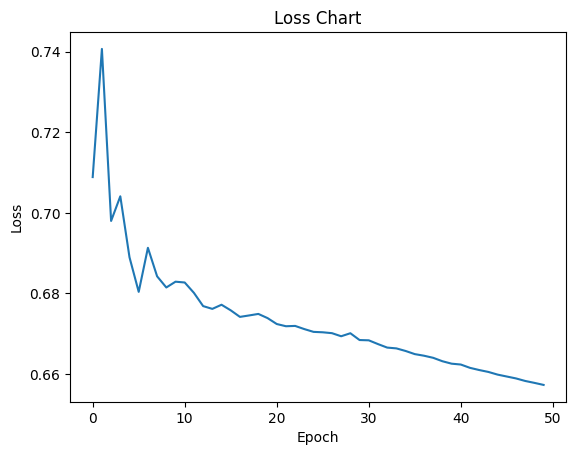

In [ ]:
e_model=train(model=e_classifier, train_loader=train_loader_e, epochs=epochs , class_weights=e_class_weights , learning_rate=e_learning_rate)

              precision    recall  f1-score   support

         0.0       1.00      0.33      0.49     16196
         1.0       0.00      0.69      0.00        26

    accuracy                           0.33     16222
   macro avg       0.50      0.51      0.25     16222
weighted avg       1.00      0.33      0.49     16222



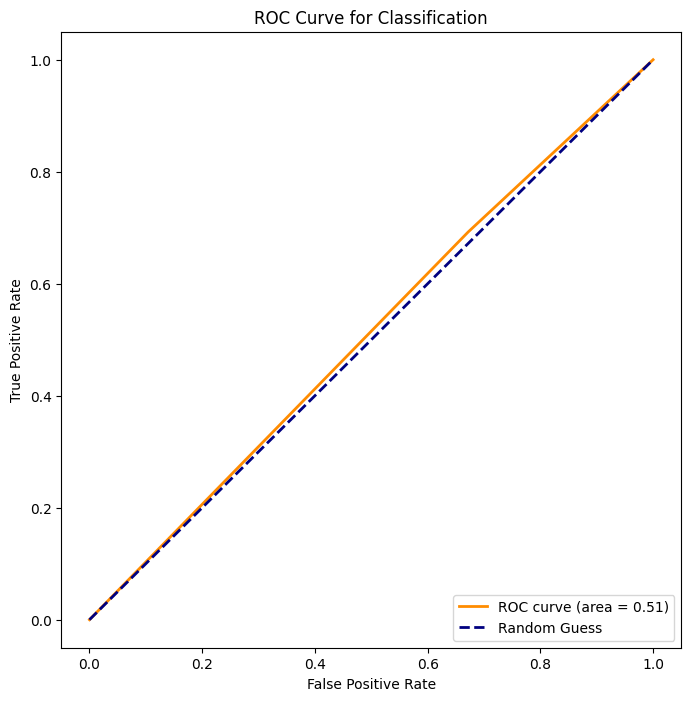

 --------------------------- 
accuracy:  0.3287510871887207


In [ ]:
acc , e_predict=evaluate(model=e_model, test_loader=test_loader_e)
print(' --------------------------- ')
print('accuracy: ',acc)

# Create Final Prediction

In [ ]:
class NodeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NodeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
class EdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EdgeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class GrpClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GrpClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
node_features = X_train_Node
edge_features = X_train_tensor_e
Grp_features =Grp_X_train
node_labels = y_train_Node
edge_labels = y_train_tensor_e
Grp_labels = Grp_y_train

In [ ]:
# Initialize models
node_classifier = NodeClassifier(input_dim=node_features.shape[1], hidden_dim=128, output_dim=2)
Grp_classifier = GrpClassifier(input_dim=Grp_features.shape[1], hidden_dim=128, output_dim=2)
edge_classifier = EdgeClassifier(input_dim=edge_features.shape[1], hidden_dim=64, output_dim=2)


In [ ]:
node_criterion = nn.CrossEntropyLoss(weight=n_class_weights)
Grp_criterion = nn.CrossEntropyLoss(weight=Grp_class_weights)
edge_criterion = nn.CrossEntropyLoss(weight=e_class_weights)

In [ ]:
optimizer = optim.Adam(list(node_classifier.parameters()) + list(Grp_classifier.parameters()) + list(edge_classifier.parameters()), lr=0.1)

In [ ]:
# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    node_logits = node_classifier(node_features)
    Grp_logits = Grp_classifier(Grp_features)
    edge_logits = edge_classifier(edge_features)

    # Compute losses
    node_loss = node_criterion(node_logits, node_labels)
    Grp_loss = node_criterion(Grp_logits, Grp_labels)
    edge_loss = edge_criterion(edge_logits, edge_labels.long())

    # Total loss (you can weight the losses if needed)
    total_loss = node_loss + edge_loss + Grp_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Node Loss: {node_loss.item()}, Edge Loss: {edge_loss.item()}')

Epoch 1/100, Node Loss: 0.7007476687431335, Edge Loss: 0.6994136571884155
Epoch 6/100, Node Loss: 0.7411178946495056, Edge Loss: 1.107591986656189
Epoch 11/100, Node Loss: 0.6987518072128296, Edge Loss: 0.718412458896637
Epoch 16/100, Node Loss: 0.6950927972793579, Edge Loss: 0.6830258369445801
Epoch 21/100, Node Loss: 0.6854108572006226, Edge Loss: 0.6814351081848145
Epoch 26/100, Node Loss: 0.6847144961357117, Edge Loss: 0.6812490820884705
Epoch 31/100, Node Loss: 0.683143138885498, Edge Loss: 0.6809812188148499
Epoch 36/100, Node Loss: 0.6826592683792114, Edge Loss: 0.6804746389389038
Epoch 41/100, Node Loss: 0.6814199090003967, Edge Loss: 0.6802200675010681
Epoch 46/100, Node Loss: 0.680841326713562, Edge Loss: 0.6802020072937012
Epoch 51/100, Node Loss: 0.6806012392044067, Edge Loss: 0.6801195740699768
Epoch 56/100, Node Loss: 0.679592490196228, Edge Loss: 0.6800472736358643
Epoch 61/100, Node Loss: 0.6789810061454773, Edge Loss: 0.6798875331878662
Epoch 66/100, Node Loss: 0.67854

              precision    recall  f1-score   support

           0       0.99      0.83      0.91     12889
           1       0.01      0.23      0.02        74

    accuracy                           0.83     12963
   macro avg       0.50      0.53      0.46     12963
weighted avg       0.99      0.83      0.90     12963



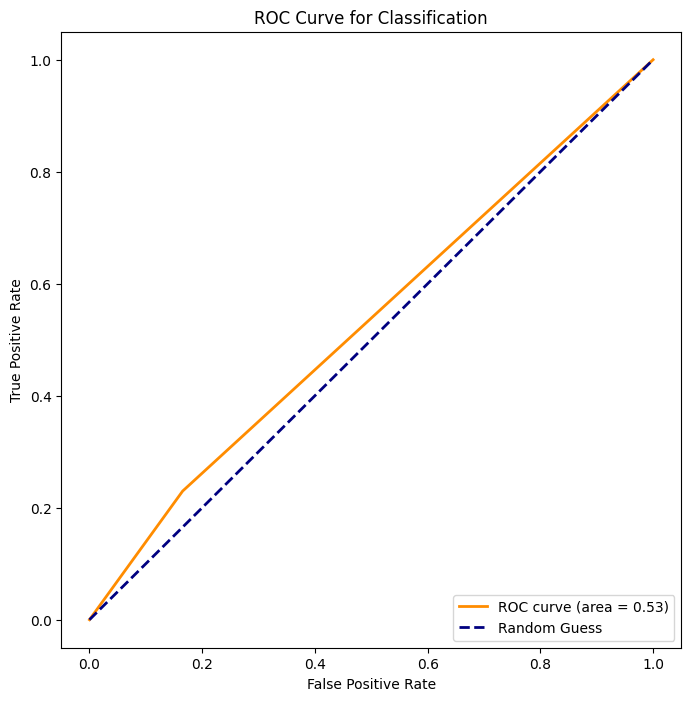

(0.8312119245529175, tensor([1, 1, 1,  ..., 0, 1, 0]))

In [ ]:
evaluate(model=node_classifier, test_loader=test_loader_node)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12948
           1       0.00      0.00      0.00         6

    accuracy                           1.00     12954
   macro avg       0.50      0.50      0.50     12954
weighted avg       1.00      1.00      1.00     12954



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


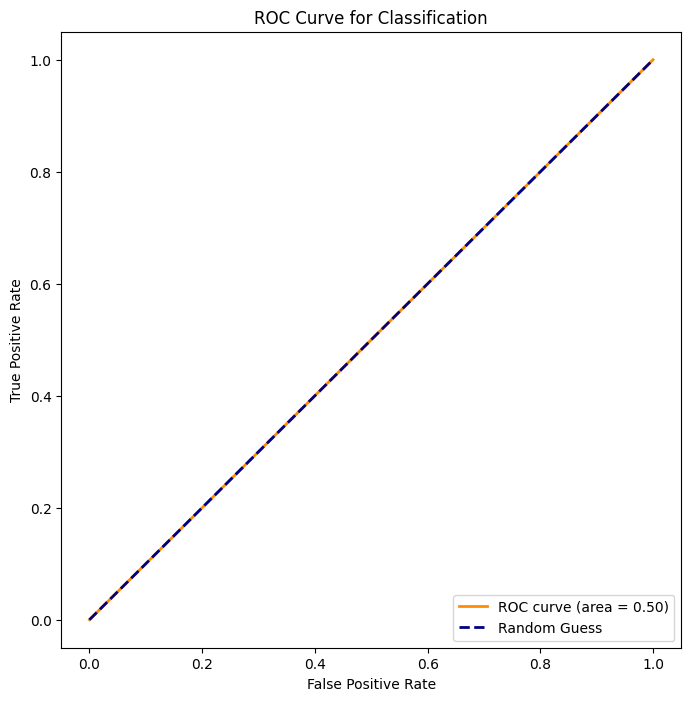

(0.9995368123054504, tensor([0, 0, 0,  ..., 0, 0, 0]))

In [ ]:
evaluate(model=Grp_classifier, test_loader=test_loader_Grp)


              precision    recall  f1-score   support

         0.0       1.00      0.14      0.25     16196
         1.0       0.00      0.88      0.00        26

    accuracy                           0.14     16222
   macro avg       0.50      0.51      0.13     16222
weighted avg       1.00      0.14      0.25     16222



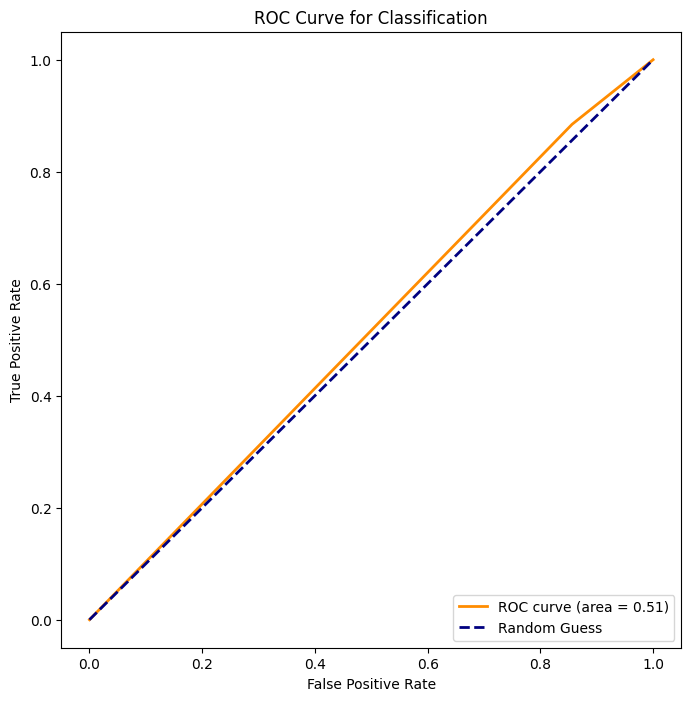

(0.1449882835149765, tensor([1, 1, 1,  ..., 1, 1, 1]))

In [ ]:
evaluate(model=edge_classifier, test_loader=test_loader_e)

# Create Model and Method

In [ ]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(16, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x


In [ ]:
def evaluate(model,test_loader):
    torch.backends.cudnn.deterministic = True
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            logits = model(inputs)
            _, predicted = torch.max(logits, 1)

            accuracy = (predicted == labels).float().mean().item()


        print(classification_report(labels, predicted))

    #--------------------Plot AUC----------------------------
        fpr, tpr, thresholds = roc_curve(labels, predicted)

        # Calculate the AUC
        roc_auc = auc(fpr, tpr)
        # Calculate the AUC
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Classification')
        plt.legend(loc='lower right')
        plt.show()

    return accuracy

In [ ]:
def train (model,train_loader , epochs , class_weights , learning_rate):
    torch.backends.cudnn.deterministic = True
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_list: list = []
    # Training loop
    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

        #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        if epoch % 5 == 0:
            print(f"In epoch {epoch}, loss: {loss:.3f})"
                )
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Chart')
    plt.show()
    return model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
def Get_class_weights(data):
    class_labels=torch.unique(data)
    class_labels=np.array(class_labels)
    y=np.array(data)
    class_weight =compute_class_weight(class_weight='balanced', classes=class_labels, y=y)
    class_weights=torch.tensor(class_weight ,  dtype = torch.float)
    return class_weights


# Create Model - SAGE Graph

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super(SAGE, self).__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [ ]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)

    logits = logits[mask]
    labels = labels[mask]

    _, predicted = torch.max(logits, 1)

    accuracy = (predicted == labels).float().mean().item()
    print(classification_report(labels, predicted))

    #--------------------Plot AUC----------------------------
    fpr, tpr, thresholds = roc_curve(labels, predicted)

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    # Calculate the AUC
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for GraphSAGE')
    plt.legend(loc='lower right')
    plt.show()


    return accuracy

In [ ]:
#model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters())

In [ ]:
best_val_acc = 0
best_test_acc = 0

features_train = graph.ndata["feat"]
labels = graph.ndata["label"]
train_mask = graph.ndata["train_mask"]
#val_mask = graph.ndata["val_mask"]
test_mask = graph.ndata["test_mask"]
#**********************New For chart*********************
EPOCHS=5
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

In [ ]:
len(labels)

202426

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_labels=torch.unique(labels)
class_labels=np.array(class_labels)
y=labels
y=np.array(y)
class_weights =compute_class_weight(class_weight='balanced', classes=class_labels, y=y)
class_weights=torch.tensor(class_weights ,  dtype = torch.float)

In [ ]:
seed=42
import tensorflow as tf

# Set a random seed for reproducibility
tf.random.set_seed(42)
num_classes=2
in_feats = features_train.shape[1]
hid_feats = 100 # Hidden layer size
out_feats = num_classes  # Number of output classes

model = SAGE(in_feats, hid_feats, out_feats)
torch.manual_seed(seed)
np.random.seed(seed)
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.4)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)



In epoch 0, loss: 0.000)
In epoch 5, loss: 0.000)
In epoch 10, loss: 0.000)
In epoch 15, loss: 0.000)
In epoch 20, loss: 0.000)
In epoch 25, loss: 0.000)


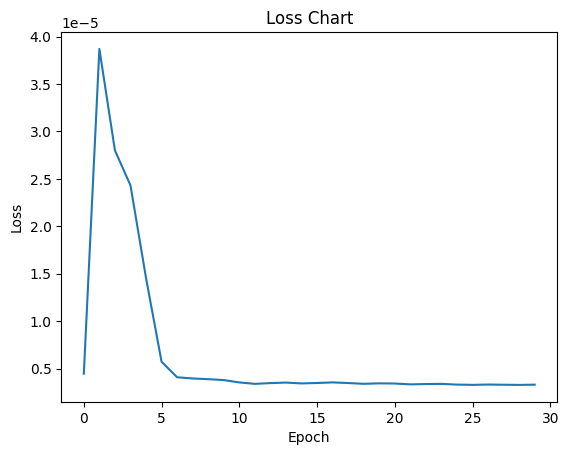

In [ ]:
num_epochs=30
loss_list: list = []
epochlist = np.zeros((num_epochs,))
# Training loop
for epoch in range(num_epochs):
    model.train()
    logits = model(graph, features_train)
    loss = criterion(logits[train_mask], labels[train_mask]) / len(train)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"In epoch {epoch}, loss: {loss:.3f})"
            )
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Chart')
plt.show()


              precision    recall  f1-score   support

           0       1.00      0.88      0.94     40428
           1       0.01      0.78      0.02        58

    accuracy                           0.88     40486
   macro avg       0.50      0.83      0.48     40486
weighted avg       1.00      0.88      0.93     40486



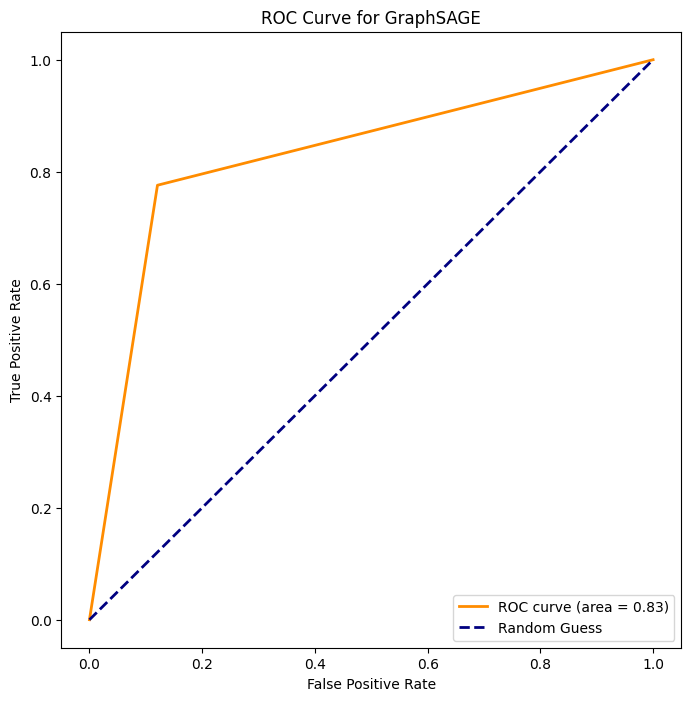

Test Accuracy: 0.8792


In [ ]:
# Evaluate on the test set
model.eval()
mask_test = (graph.ndata['test_mask'] == True)  # Assuming you have a test mask
accuracy = evaluate(model, graph, features_train, labels, mask_test)

print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# Save the model state dictionary
torch.save(model.state_dict(), path + 'model_state_SagNodeClassification.pth')

# Model For Multi Task Learning

In [ ]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(16, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x

In [ ]:
class n_Autoencoder(nn.Module):
    def __init__(self , input_dim):
        super(n_Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self , input_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64,16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class Grp_Autoencoder(nn.Module):
    def __init__(self , input_dim):
        super(Grp_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            #nn.Linear(128, 32),
            #nn.ReLU(),
            nn.Linear(128, 16),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            #nn.Linear(32, 128),
            #nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Sigmoid for output between 0 and 1
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
node_features = X_train_Node
edge_features = X_train_tensor_e
Grp_features =Grp_X_train
node_labels = y_train_Node
edge_labels = y_train_tensor_e
Grp_labels = Grp_y_train

In [ ]:
n_class_weights=Get_class_weights(train_graph.ndata['label'])
e_class_weights=Get_class_weights(train_graph.edata['eLabel'])
Grp_class_weights=Get_class_weights(Grp_train_graph.ndata['label'])

In [ ]:
learning_rate_Grp=0.9
batch_size_Grp =135308
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp, shuffle=False )
#----------------------------------------------------
learning_rate_n=0.02
batch_size_n =135447
train_dateset=torch.utils.data.TensorDataset(X_train_Node,y_train_Node)
train_loader_node=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_n, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(X_test_Node,y_test_Node)
test_loader_node=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_n, shuffle=False )
#----------------------------------------------------
e_learning_rate=0.01
batch_size_e =230907
train_dateset_e=torch.utils.data.TensorDataset(X_train_tensor_e,y_train_tensor_e)
train_loader_e=torch.utils.data.DataLoader(train_dateset_e , batch_size=batch_size_e, shuffle=True)
test_dataset_e=torch.utils.data.TensorDataset(X_test_tensor_e,y_test_tensor_e)
test_loader_e=torch.utils.data.DataLoader(test_dataset_e , batch_size=batch_size_e, shuffle=False )


In [ ]:
autoencoder = n_Autoencoder(input_dim=node_features.shape[1])
node_classifier = Classifier(autoencoder.encoder )

autoencoder = Autoencoder(input_dim=X_train_tensor_e.shape[1])
edge_classifier = Classifier(autoencoder.encoder)

autoencoder = Grp_Autoencoder(input_dim=Grp_features.shape[1])
classifier = Classifier(autoencoder.encoder)


In [ ]:
node_criterion = nn.CrossEntropyLoss(weight=n_class_weights)
Grp_criterion = nn.CrossEntropyLoss(weight=Grp_class_weights)
edge_criterion = nn.CrossEntropyLoss(weight=e_class_weights)

In [ ]:
optimizer = optim.Adam(list(node_classifier.parameters()) + list(Grp_classifier.parameters()) + list(edge_classifier.parameters()), lr=0.85)

In [ ]:
# Training loop
torch.backends.cudnn.deterministic = True
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    node_logits = node_classifier(node_features)
    Grp_logits = Grp_classifier(Grp_features)
    edge_logits = edge_classifier(edge_features)

    # Compute losses
    node_loss = node_criterion(node_logits, node_labels)
    Grp_loss = node_criterion(Grp_logits, Grp_labels)
    edge_loss = edge_criterion(edge_logits, edge_labels.long())

    # Total loss (you can weight the losses if needed)
    total_loss = node_loss + edge_loss + Grp_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Node Loss: {node_loss.item()}, Edge Loss: {edge_loss.item()} , Grp Loss: {Grp_loss.item()}')

Epoch 1/50, Node Loss: 0.6911112666130066, Edge Loss: 0.7017075419425964 , Grp Loss: 0.2814788222312927
Epoch 6/50, Node Loss: 0.8412317633628845, Edge Loss: 34.33340072631836 , Grp Loss: 0.5217742323875427
Epoch 11/50, Node Loss: 0.7381830811500549, Edge Loss: 10.106988906860352 , Grp Loss: 0.44041708111763
Epoch 16/50, Node Loss: 0.6989423632621765, Edge Loss: 1.8404465913772583 , Grp Loss: 0.4174439609050751
Epoch 21/50, Node Loss: 0.6963154077529907, Edge Loss: 3.0080738067626953 , Grp Loss: 0.3512382507324219
Epoch 26/50, Node Loss: 0.7025222182273865, Edge Loss: 0.8527799248695374 , Grp Loss: 0.3436720073223114
Epoch 31/50, Node Loss: 0.697492778301239, Edge Loss: 0.70855712890625 , Grp Loss: 0.34554511308670044
Epoch 36/50, Node Loss: 0.693420946598053, Edge Loss: 0.6967991590499878 , Grp Loss: 0.32567891478538513
Epoch 41/50, Node Loss: 0.6934640407562256, Edge Loss: 0.73385089635849 , Grp Loss: 0.3111082911491394
Epoch 46/50, Node Loss: 0.6940814256668091, Edge Loss: 0.6936003

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12948
           1       0.02      0.67      0.03         6

    accuracy                           0.98     12954
   macro avg       0.51      0.82      0.51     12954
weighted avg       1.00      0.98      0.99     12954



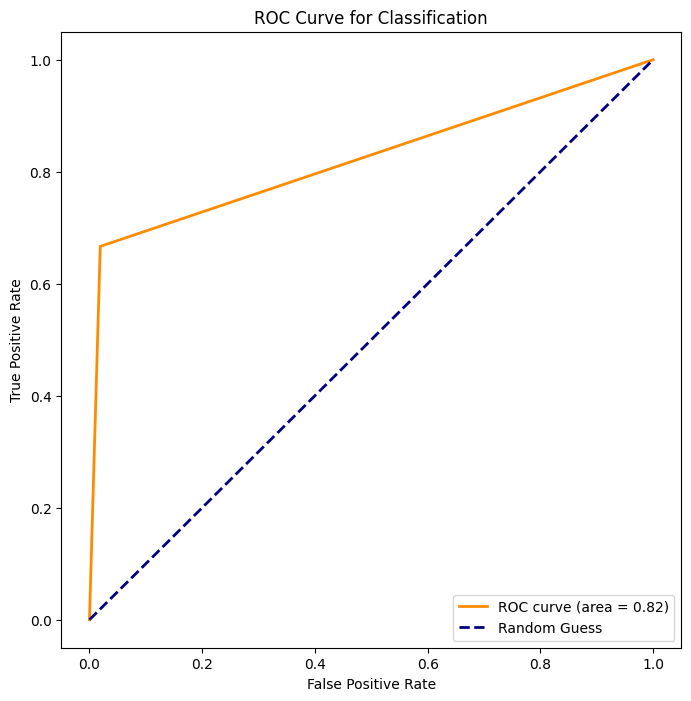

(0.9807009696960449, tensor([1, 1, 0,  ..., 0, 0, 0]))

In [ ]:
evaluate(model=Grp_classifier, test_loader=test_loader_Grp)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12889
           1       0.01      1.00      0.01        74

    accuracy                           0.01     12963
   macro avg       0.00      0.50      0.01     12963
weighted avg       0.00      0.01      0.00     12963



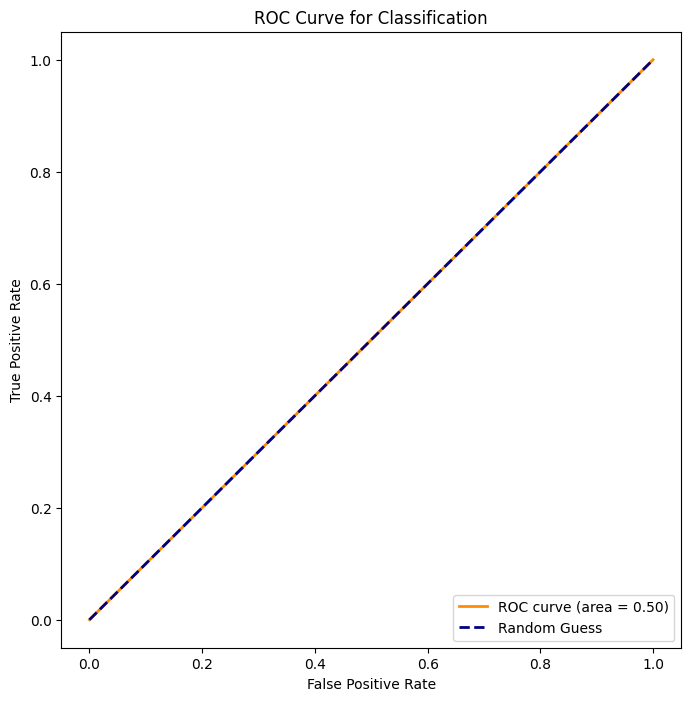

(0.0057085552252829075, tensor([1, 1, 1,  ..., 1, 1, 1]))

In [ ]:
evaluate(model=node_classifier, test_loader=test_loader_node)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     16196
         1.0       0.00      1.00      0.00        26

    accuracy                           0.00     16222
   macro avg       0.00      0.50      0.00     16222
weighted avg       0.00      0.00      0.00     16222



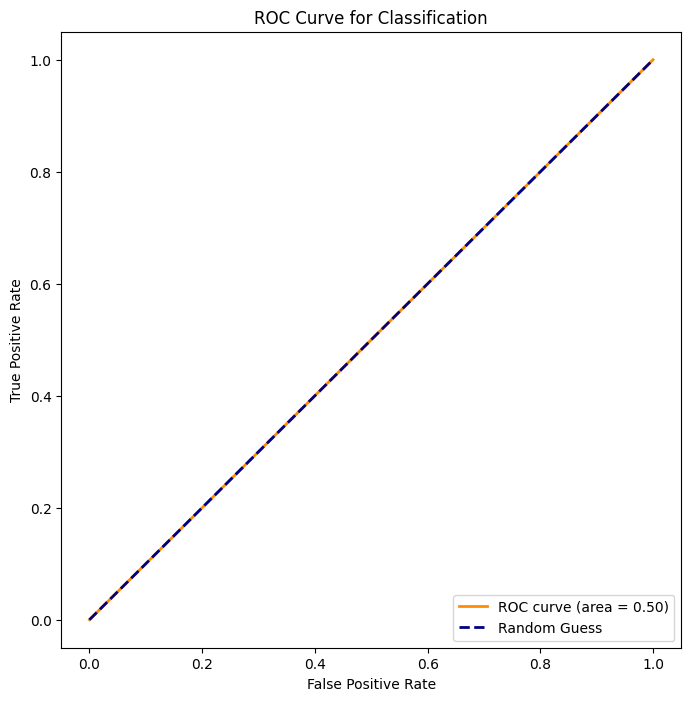

(0.0016027616802603006, tensor([1, 1, 1,  ..., 1, 1, 1]))

In [ ]:
evaluate(model=edge_classifier, test_loader=test_loader_e)

# Sample code for Dual Loss Classification

In [ ]:
# Define the Anomaly Detection Model
class AnomalyDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AnomalyDetector, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_normal = nn.Linear(hidden_dim, 1)  # Output for normal samples
        self.fc_anomalous = nn.Linear(hidden_dim, 1)  # Output for anomalous samples
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        normal_output = self.sigmoid(self.fc_normal(x))
        anomalous_output = self.sigmoid(self.fc_anomalous(x))
        return normal_output, anomalous_output


In [ ]:
# Sample data
normal_data = torch.tensor([[0.2, 0.1], [0.4, 0.2], [0.6, 0.3]], dtype=torch.float32)
anomalous_data = torch.tensor([[2.0, 1.5], [1.8, 1.2], [1.0, 0.8]], dtype=torch.float32)

In [ ]:
normal_data

tensor([[0.2000, 0.1000],
        [0.4000, 0.2000],
        [0.6000, 0.3000]])

In [ ]:
anomalous_data

tensor([[2.0000, 1.5000],
        [1.8000, 1.2000],
        [1.0000, 0.8000]])

In [ ]:
model = AnomalyDetector(input_dim=2, hidden_dim=64)

In [ ]:
normal_loss_func = nn.BCELoss()  # Binary Cross-Entropy Loss for normal samples
anomalous_loss_func = nn.BCELoss()  # Binary Cross-Entropy Loss for anomalous samples

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    normal_output, anomalous_output = model(normal_data)

    # Compute losses
    normal_loss = normal_loss_func(normal_output, torch.zeros_like(normal_output))  # Target label for normal samples is 0
    anomalous_loss = anomalous_loss_func(anomalous_output, torch.ones_like(anomalous_output))  # Target label for anomalous samples is 1

    # Total loss
    total_loss = normal_loss + anomalous_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Normal Loss: {normal_loss.item()}, Anomalous Loss: {anomalous_loss.item()}')

Epoch 1/100, Normal Loss: 0.14330005645751953, Anomalous Loss: 0.17236734926700592
Epoch 6/100, Normal Loss: 0.13378535211086273, Anomalous Loss: 0.1612350344657898
Epoch 11/100, Normal Loss: 0.12498895078897476, Anomalous Loss: 0.1509053111076355
Epoch 16/100, Normal Loss: 0.11686258763074875, Anomalous Loss: 0.14132831990718842
Epoch 21/100, Normal Loss: 0.10935888439416885, Anomalous Loss: 0.13245533406734467
Epoch 26/100, Normal Loss: 0.10243212431669235, Anomalous Loss: 0.1242382749915123
Epoch 31/100, Normal Loss: 0.09603854268789291, Anomalous Loss: 0.11663087457418442
Epoch 36/100, Normal Loss: 0.0901365578174591, Anomalous Loss: 0.10958866029977798
Epoch 41/100, Normal Loss: 0.08468698710203171, Anomalous Loss: 0.10306939482688904
Epoch 46/100, Normal Loss: 0.07965320348739624, Anomalous Loss: 0.09703297168016434
Epoch 51/100, Normal Loss: 0.07500109821557999, Anomalous Loss: 0.09144166857004166
Epoch 56/100, Normal Loss: 0.07069900631904602, Anomalous Loss: 0.0862605348229408

In [ ]:
normal_data_tst = torch.tensor([[0.3, 0.4], [0.1, 0.2], [0.7, 0.2]], dtype=torch.float32)
anomalous_data_tst = torch.tensor([[1.0, 4.5], [3.8, 2.2], [2.0, 1.8]], dtype=torch.float32)